# Two Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a two harmonics.

In [1]:
import copy
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1', 'k=2_evap=0_1']
# exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
# exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
tau_lw = [isca_tools.load_namelist(exp_dir+exp_name[i])['two_stream_gray_rad_nml']['odp'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/2 [00:00<?, ?it/s]

Removing height from var_keep


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [5]:
ds = [get_annual_zonal_mean(ds_base[i]) for i in range(n_exp)]
p_surface = float(ds[0].pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = [ds[i].w_atm.mean(dim='time') for i in range(n_exp)]

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds[0].lat.size
n_time = ds[0].time.size
t_surf = np.asarray([ds[i].t_surf.to_numpy().transpose() for i in range(n_exp)])
t_surf_anom = t_surf - np.mean(t_surf, axis=-1)[:, :, np.newaxis]

## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

If we can approximate $\Gamma^{\downarrow} \approx \lambda_0 + \lambda T'(t)$ then an analytic solution for temperature anomaly $T'(t)$ is possible. Given this linear approximation, we look at the effect of increasing the number of harmonics. 

It seems that at all latitudes, there is not much difference between the 2 and 5 harmonic direct fit, so it makes sense to only go up to 2 harmonics.

For all latitudes, there seems to be a big difference between the linear fit and the direct fit; thus it makes sense to see if we can go beyond the linear fit to $\Gamma$.

In [7]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_exp, n_lat, n_time)) for key in ['2_harmonic', '5_harmonic']}
temp_anom_fourier_fit_coefs = {key: np.zeros((n_exp, n_lat, 2*int(key[0])+1)) for key in ['2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds[0].time, ds[0].swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds[0].time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        for j in range(n_exp):
            temp_anom_fourier_fit[key][j, i], temp_anom_fourier_fit_coefs[key][j, i, :int(key[0])+1], \
                temp_anom_fourier_fit_coefs[key][j, i, int(key[0])+1:] = fourier.get_fourier_fit(ds[j].time, t_surf_anom[j, i],
                                                                                                 int(key.replace('_harmonic', '')))
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=-1)[:, :, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds[0].time[0]), 'max': int(ds[0].time[int(ds[0].time.size/2)])}
smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day

time_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}
for key in time_extrema_temp['min']:
    for j in range(n_exp):
        for i in range(n_lat):
            # No smoothing for '1_harmonic' as already fit smooth fourier solution
            time_extrema_temp['min'][key][j, i], time_extrema_temp['max'][key][j, i], amp_extrema_temp['min'][key][j, i], \
                amp_extrema_temp['max'][key][j, i] = get_temp_extrema_numerical(ds[j].time, t_surf_anom[j, i], smooth_ndays_temp_extrema)

In [8]:
# General plotting info
plot_lat_approx = 85
plot_lat_ind = np.argmin(np.abs(ds[0].lat-plot_lat_approx).to_numpy())
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds[0].time[0]-1, ds[0].time[-1]+1]
ax_lims_lat = [np.floor(ds[0].lat[0]), np.ceil(ds[0].lat[-1])]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': default_colors[0], 'square': default_colors[1], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'linear_phase': default_colors[0], 
                'square_phase': default_colors[1], '6_order_phase': default_colors[3], 'square_phase_fourier': default_colors[1],
                '6_order_phase_fourier': default_colors[3]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--', 'linear_phase_0': '-', 
                    'square': ':', 'square_phase': '--', '6_order_phase': '--', 'square_phase_fourier': '-', '6_order_phase_fourier': '-'}
linestyle_exp = ['-', ':']
color_harmonic = {'1_harmonic': 'k', '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
color_var = {'sum': 'k', 'w_atm': default_colors[2], 'drag_q': default_colors[1], 'rh': default_colors[0], 'temp_diseqb': default_colors[4], 
             'ps': default_colors[5], 'emission_factor': default_colors[0], 't_surf': default_colors[3]}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'drag_q': None, 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}
labels_exp = [f'$\kappa={tau_lw[i]}$' for i in range(n_exp)]
# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

resample = False        # whether to resample data so evenly spaced in x before finding polynomial coefficents.

## $\Gamma$ Empirical Fit

When looking at one harmonic, the following approximation, with three parameters that need to be found, seemed to provide a large improvement:

$\Gamma(t) \approx \lambda_0 + \lambda T'(t) + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4))$

Below, we see that this does not help with 2 harmonics, so something else must be the issue.

With 2 harmonics, we can include powers of temperature in the surface energy budget, so we investigate the effect of including higher powers. It seems that there is a large improvement from including a squared term:

$\Gamma(t) \approx \lambda_0 + \lambda T'(t) + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda_{sq}T'(t)^2$

But not much more is gained by going up to the 6th power, so we assume the above approximation is the best we can do from just the temperature anomaly, $T'(t)$. To go beyond this, we compute the 2nd up to $N^{th}$ harmonic (where we seek an $N$ harmonic fourier solution for $T$) of the fourier series approximation of the residual after fitting 10 polynomials as well as a phase shift. This is to quantify the non-temperature dependent part of $\Gamma$, we exclude the 0th and 1st harmonic as they will be included in the polynomial and phase fitting stuff. With this, the final approximation for $\Gamma$ is:

$\lambda_0 + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda T'(t) + \lambda_{sq}T'(t)^2 + \sum_{n=2}^N (\Lambda_{n, cos}\cos(2n\pi t/\mathcal{T}) + \Lambda_{n, sin}\sin(2n\pi t/\mathcal{T}))$

With this final form of $\Gamma$, the error is pretty small, indicating this is pretty good.

#### Numerical Solution of Temperature
The error reduction in $\Gamma$ is also reflected in the numerical solution for the 2 harmonic Fourier expansion of temperature which satisfies the differential equation.

The numerical solution with the final form of $\Gamma$ is pretty close to the direct fit, although there does seem to be a systematic offset. But is definately good enough for our purposes.

In [9]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = np.asarray([(ds[i].lwup_sfc-ds[i].lwdn_sfc).transpose().to_numpy() for i in range(n_exp)])
gamma_comp['lh'][key] = np.asarray([(ds[i].flux_lhe).transpose().to_numpy() for i in range(n_exp)])
gamma_comp['sh'][key] = np.asarray([(ds[i].flux_t).transpose().to_numpy() for i in range(n_exp)])

heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
n_approx_params = {'linear': 2, 'square': 3, '6_order': 7, 'square_phase_fourier': 6}
for key in ['linear', 'square', '6_order']:
    n_approx_params[key+'_phase'] = n_approx_params[key]+1

for key in ['linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_exp, n_lat, n_approx_params[key]))
        gamma_comp[key2][key] = np.zeros((n_exp, n_lat, n_time))
        for i in range(n_lat):
            for j in range(n_exp):
                if 'fourier' in key:
                    # Last 4 parameters are the normal polyfit_phase parameters
                    gamma_comp_params[key2][key][j, i, 2:], param_fourier_amp_use, param_fourier_phase_use = \
                        numerical.polyfit_phase(t_surf_anom[j, i], gamma_comp[key2]['simulated'][j, i],
                                                n_approx_params[key.replace('_phase_fourier', '')] - 1, resample=resample,
                                                fourier_harmonics=np.asarray([2]))
                    # first 2 parameters are fourier coefficients - convert to cos and sin coefficients so can add together
                    gamma_comp_params[key2][key][j, i, :2] = fourier.coef_conversion(param_fourier_amp_use[2], param_fourier_phase_use[1])
                    gamma_comp[key2][key][j, i] = numerical.polyval_phase(gamma_comp_params[key2][key][j, i, 2:], t_surf_anom[j, i],
                                                                       coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
                elif 'phase' in key:
                    gamma_comp_params[key2][key][j, i] = numerical.polyfit_phase(t_surf_anom[j, i], gamma_comp[key2]['simulated'][j, i],
                                                                              n_approx_params[key.replace('_phase', '')] - 1, resample=resample)
                    gamma_comp[key2][key][j, i] = numerical.polyval_phase(gamma_comp_params[key2][key][j, i], t_surf_anom[j, i])
                else:
                    gamma_comp_params[key2][key][j, i] = numerical.polyfit_phase(t_surf_anom[j, i], gamma_comp[key2]['simulated'][j, i],
                                                                              n_approx_params[key]-1, include_phase=False, resample=resample)[1:]
                    gamma_comp[key2][key][j, i] = np.polyval(gamma_comp_params[key2][key][j, i], t_surf_anom[j, i])

In [10]:
gamma = {'simulated':np.asarray([np.asarray(ds[j].lwup_sfc - ds[j].lwdn_sfc + ds[j].flux_lhe + ds[j].flux_t).transpose() for j in range(n_exp)])}
gamma_params = {}      # lowest power is last
arg_ind = {'linear': [4, 5], 'linear_phase': [2, 4, 5], 'square': [3, 4, 5], 'square_phase': [2, 3, 4, 5], 'square_phase_fourier': np.arange(6)}
for key in ['linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier']:
    gamma_params[key] = np.zeros((n_exp, n_lat, n_approx_params['square_phase_fourier']))
    gamma[key] = np.zeros((n_exp, n_lat, n_time))
    gamma_params[key][:, :, arg_ind[key]] = gamma_comp_params['lw'][key]+gamma_comp_params['lh'][key]+gamma_comp_params['sh'][key]
    for j in range(n_exp):
        for i in range(n_lat):
            param_fourier_amp_use, param_fourier_phase_use = fourier.coef_conversion(cos_coef=gamma_params[key][j, i, 0],
                                                                                     sin_coef=gamma_params[key][j, i, 1])
            # fourier coefs are for 2nd harmonic, so account for 0th and 1st harmonic as being 0
            param_fourier_amp_use = np.asarray([0, 0, param_fourier_amp_use])
            param_fourier_phase_use = np.asarray([0, param_fourier_phase_use])
            gamma[key][j, i] = numerical.polyval_phase(gamma_params[key][j, i, 2:], t_surf_anom[j, i],
                                                       coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
gamma_params['6_order_phase'] = np.zeros((n_exp, n_lat, n_approx_params['6_order_phase']))
gamma['6_order_phase'] = np.zeros((n_exp, n_lat, n_time))
gamma['6_order_phase_fourier'] = np.zeros((n_exp, n_lat, n_time))
for i in range(n_lat):
    for j in range(n_exp):
        gamma_params['6_order_phase'][j, i] = numerical.polyfit_phase(t_surf_anom[j, i], gamma['simulated'][j, i], 6, resample=resample)
        gamma['6_order_phase'][j, i] = numerical.polyval_phase(gamma_params['6_order_phase'][j, i], t_surf_anom[j, i])
        param_poly_use, param_fourier_amp_use, param_fourier_phase_use = \
            numerical.polyfit_phase(t_surf_anom[j, i], gamma['simulated'][j, i], 6, resample=resample, fourier_harmonics=np.arange(2, 6+1))
        gamma['6_order_phase_fourier'][j, i] = numerical.polyval_phase(param_poly_use, t_surf_anom[j, i], coefs_fourier_amp=param_fourier_amp_use,
                                                                       coefs_fourier_phase=param_fourier_phase_use)

In [11]:
# Get approximate temperature for each level in hierarchy of gamma approximation
temp_anom_numerical = {key: np.zeros((n_exp, n_lat, n_time)) for key in ['linear', 'linear_phase', 'square', 'square_phase', '6_order_phase',
                                                                  'square_phase_fourier', '6_order_phase_fourier', 'square_fourier']}
# 3 amplitude coefficients (1st is zero as fitting anomaly) followed by 2 phase coefficients
temp_anom_numerical_fit_coefs = {key: np.zeros((n_exp, n_lat, 5)) for key in ['linear', 'linear_phase', 'square', 'square_phase', '6_order_phase',
                                                                  'square_phase_fourier', '6_order_phase_fourier', 'square_fourier']}
for key in temp_anom_numerical:
    for i in range(n_lat):
        for j in range(n_exp):
            temp_anom_numerical[key][j, i], temp_anom_numerical_fit_coefs[key][j, i, :3], temp_anom_numerical_fit_coefs[key][j, i, 3:] = \
                get_temp_fourier_numerical(ds[j].time.to_numpy(), t_surf_anom[j, i], gamma['simulated'][j, i], ds[j].swdn_sfc.isel(lat=i).to_numpy(),
                                           heat_capacity, n_harmonics=2,
                                           deg_gamma_fit=n_approx_params[key.replace('_phase', '').replace('_fourier', '')]-1,
                                           phase_gamma_fit='phase' in key, resample=resample, gamma_fourier_term='fourier' in key)

temp_anom_analytic = {}
temp_anom_analytic_fit_coefs = {}
for key in ['square_phase_fourier']:
    temp_anom_analytic[key] = np.zeros((n_exp, n_lat, n_time))
    temp_anom_analytic_fit_coefs[key] = np.zeros((n_exp, n_lat, 5))
    for i in range(n_lat):
        for j in range(n_exp):
            temp_anom_analytic[key][j, i], temp_anom_analytic_fit_coefs[key][j, i, :3], temp_anom_analytic_fit_coefs[key][j, i, 3:] =\
                get_temp_fourier_analytic(ds[j].time.to_numpy(), ds[j].swdn_sfc.isel(lat=i).to_numpy(), heat_capacity,
                                          gamma_params[key][j, i, 4], gamma_params[key][j, i, 2], gamma_params[key][j, i, 3],
                                          gamma_params[key][j, i, 0], gamma_params[key][j, i, 1], n_harmonics_sw=2)[:3]

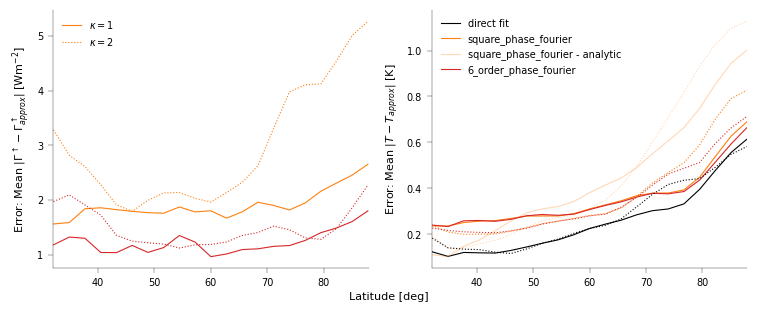

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for j in range(n_exp):
    ax[1].plot(ds[j].lat, error_func(smooth_func(t_surf_anom[j]), temp_anom_fourier_fit['2_harmonic'][j], norm=False),
               color=color_approx['direct fit'], linestyle=linestyle_exp[j], label='direct fit' if j==0 else None)
    # ax[1].plot(ds[j].lat, error_func(smooth_func(t_surf_anom[j]), temp_anom_fourier_fit['5_harmonic'][j], norm=False),
    #        color=color_approx['direct fit'], linestyle=':', label='direct fit (5)' if j==0 else None)
    for key in ['square_phase_fourier', '6_order_phase_fourier']:
        ax[0].plot(ds[j].lat, error_func(smooth_func(gamma['simulated'][j]), gamma[key][j]), color=color_approx[key],
                   label=labels_exp[j] if key=='square_phase_fourier' else None, linestyle=linestyle_exp[j])
        ax[1].plot(ds[j].lat, error_func(smooth_func(t_surf_anom[j]), temp_anom_numerical[key][j]), color=color_approx[key],
                   label=key if j==0 else None, linestyle=linestyle_exp[j])
        if key in temp_anom_analytic:
            ax[1].plot(ds[j].lat, error_func(smooth_func(t_surf_anom[j]), temp_anom_analytic[key][j]), color=color_approx[key],
                       linestyle=linestyle_exp[j], alpha=0.3, label=f'{key} - analytic' if j==0 else None)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[0].set_xlim(ax_lims_lat)
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
fig.supxlabel('Latitude [deg]', fontsize=8)
plt.show()

### Comparison between Numerical and Analytic square_phase_fourier
If the square term is included in $\Gamma$, an analytic solution is only possible if we assume $T^2$ is dominated by the 1st harmonic. Below, we compare the analytic and numerical solutions.

I first look at how the fouirer coefficients found differ between numerical and analytical.

In [13]:
# Ensure in correct range
for i in range(n_lat):
    for j in range(n_exp):
        for k in range(2):
            if temp_anom_numerical_fit_coefs['square_phase_fourier'][j, i, -1-k] < -np.pi:
                temp_anom_numerical_fit_coefs['square_phase_fourier'][j, i, -1-k] += 2*np.pi
            elif temp_anom_numerical_fit_coefs['square_phase_fourier'][j, i, -1-k] > np.pi:
                temp_anom_numerical_fit_coefs['square_phase_fourier'][j, i, -1-k] -= 2*np.pi

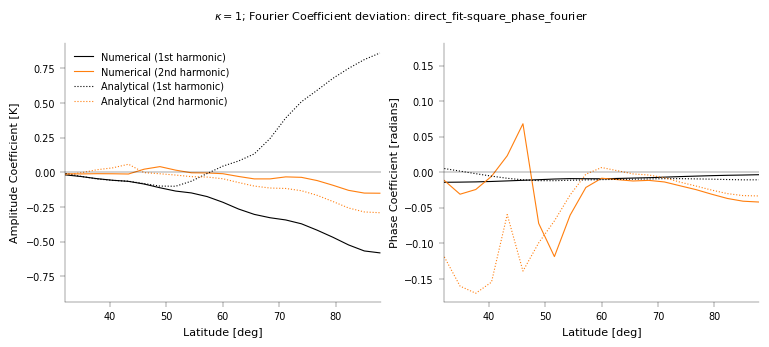

In [14]:
plot_exp_ind = 0
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
sign_use = np.sign(temp_anom_fourier_fit_coefs['2_harmonic'][plot_exp_ind, :, :])
for i in range(2):
    ax[i].plot(ds[0].lat, temp_anom_fourier_fit_coefs['2_harmonic'][plot_exp_ind, :, 2*i+1] -
               sign_use[:, 2*i+1] * np.abs(temp_anom_numerical_fit_coefs['square_phase_fourier'][plot_exp_ind, :, 2*i+1]),
               color='k', label='Numerical (1st harmonic)')
    ax[i].plot(ds[0].lat, temp_anom_fourier_fit_coefs['2_harmonic'][plot_exp_ind, :, 2*i+2] -
               sign_use[:, 2*i+2] * np.abs(temp_anom_numerical_fit_coefs['square_phase_fourier'][plot_exp_ind, :, 2*i+2]),
               color=default_colors[1], label='Numerical (2nd harmonic)')
    ax[i].plot(ds[0].lat, temp_anom_fourier_fit_coefs['2_harmonic'][plot_exp_ind, :, 2*i+1] -
               sign_use[:, 2*i+1] * np.abs(temp_anom_analytic_fit_coefs['square_phase_fourier'][plot_exp_ind, :, 2*i+1]),
               color='k', linestyle=':', label='Analytical (1st harmonic)')
    ax[i].plot(ds[0].lat, temp_anom_fourier_fit_coefs['2_harmonic'][plot_exp_ind, :, 2*i+2] -
               sign_use[:, 2*i+2] * np.abs(temp_anom_analytic_fit_coefs['square_phase_fourier'][plot_exp_ind, :, 2*i+2]),
               color=default_colors[1], linestyle=':', label='Analytical (2nd harmonic)')
for ax_use in ax:
    ax_use.set_ylim(-np.max(np.abs(ax_use.get_ylim())), np.max(np.abs(ax_use.get_ylim())))
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Latitude [deg]')
ax[0].legend()
ax[0].set_xlim(ax_lims_lat)
ax[0].set_ylabel('Amplitude Coefficient [K]')
ax[1].set_ylabel('Phase Coefficient [radians]')
fig.suptitle(f'{labels_exp[plot_exp_ind]}; Fourier Coefficient deviation: direct_fit-square_phase_fourier', fontsize=8)
plt.show()
# plt.plot(temp_anom_fourier_fit_coefs['2_harmonic'][0, :, 2] - temp_anom_analytic_fit_coefs['square_phase_fourier'][0, :, 2])
# plt.plot(temp_anom_fourier_fit_coefs['2_harmonic'][0, :, 1] - temp_anom_numerical_fit_coefs['square_phase_fourier'][0, :, 1])
# plt.plot(temp_anom_fourier_fit_coefs['2_harmonic'][0, :, 2] - temp_anom_numerical_fit_coefs['square_phase_fourier'][0, :, 2])

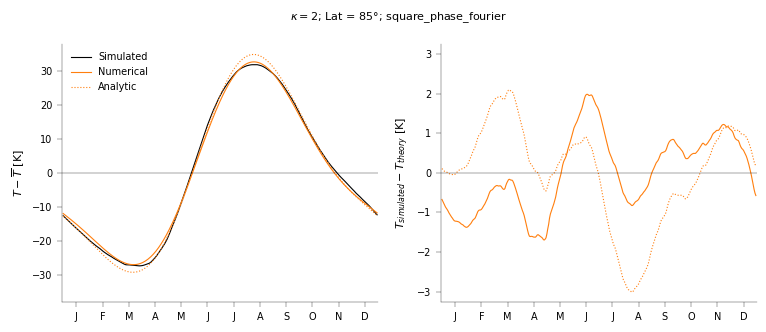

In [60]:
plot_exp_ind = 1
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds[plot_exp_ind].time, t_surf_anom[plot_exp_ind, plot_lat_ind], color='k', label='Simulated')
for key in ['square_phase_fourier']:
    ax[0].plot(ds[plot_exp_ind].time, temp_anom_numerical[key][plot_exp_ind, plot_lat_ind], color=color_approx[key], label='Numerical')
    ax[0].plot(ds[plot_exp_ind].time, temp_anom_analytic[key][plot_exp_ind, plot_lat_ind], color=color_approx[key], linestyle=':', label='Analytic')
    ax[1].plot(t_surf_anom[plot_exp_ind, plot_lat_ind]-temp_anom_numerical[key][plot_exp_ind, plot_lat_ind], color=color_approx[key])
    ax[1].plot(t_surf_anom[plot_exp_ind, plot_lat_ind]-temp_anom_analytic[key][plot_exp_ind, plot_lat_ind], color=color_approx[key], linestyle=':')
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[1].set_ylabel('$T_{simulated} - T_{theory}$ [K]')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_ylim(-np.max(np.abs(ax[i].get_ylim())), np.max(np.abs(ax[i].get_ylim())))
fig.suptitle(f'{labels_exp[plot_exp_ind]}; Lat = ${ds[0].lat[plot_lat_ind]:.0f}\degree$; square_phase_fourier', fontsize=8)
plt.show()

## Extrema
Next we look at the times and amplitudes of the extrema, as calculated from the numerical Fourier solutions for $T'(t)$.

We can see that the broad latitudinal trends are captured by the most simple linear approximation, indicating that the latitudinal variation in
insolation is mainly responsible for this.

The effect of $\lambda_{phase}$ is most apparent at low latitudes - reducing amplitude of extrema and shifting them to occur later in the year i.e. an increase in effective heat capacity.

The effect of $\lambda_{sq}$ is most apparent at high latitudes - increasing (reducing) amplitude and causing a shift later (earlier) in the
year of minima (maxima).

The effect of the temperature independent Fourier term is most apparent in the minima - it increases the amplitude and causes minima to occur
earlier in the year.

The square_phase_fourier fit is very similar to the direct fit, which is indicative of the best we can hope for with just two harmonics.
The main discrepancy to the direct fit is at high latitudes in the phase of the minima.

In [16]:
for key in ['direct fit', 'square_phase_fourier', '6_order_phase_fourier']:
    for key2 in time_extrema_temp:
        time_extrema_temp[key2][key] = np.zeros((n_exp, n_lat))
        amp_extrema_temp[key2][key] = np.zeros((n_exp, n_lat))
        if key in temp_anom_analytic:
            time_extrema_temp[key2][key+'_analytic'] = np.zeros((n_exp, n_lat))
            amp_extrema_temp[key2][key+'_analytic'] = np.zeros((n_exp, n_lat))
    for i in range(n_lat):
        for j in range(n_exp):
            time_extrema_temp['min'][key][j, i], time_extrema_temp['max'][key][j, i], amp_extrema_temp['min'][key][j, i], \
                amp_extrema_temp['max'][key][j, i] = \
            get_temp_extrema_numerical(ds[j].time, temp_anom_fourier_fit['2_harmonic'][j, i] if key=='direct fit' else temp_anom_numerical[key][j, i])
            if key in temp_anom_analytic:
                time_extrema_temp['min'][key+'_analytic'][j, i], time_extrema_temp['max'][key+'_analytic'][j, i], \
                    amp_extrema_temp['min'][key+'_analytic'][j, i], amp_extrema_temp['max'][key+'_analytic'][j, i] = \
            get_temp_extrema_numerical(ds[j].time, temp_anom_analytic[key][j, i])

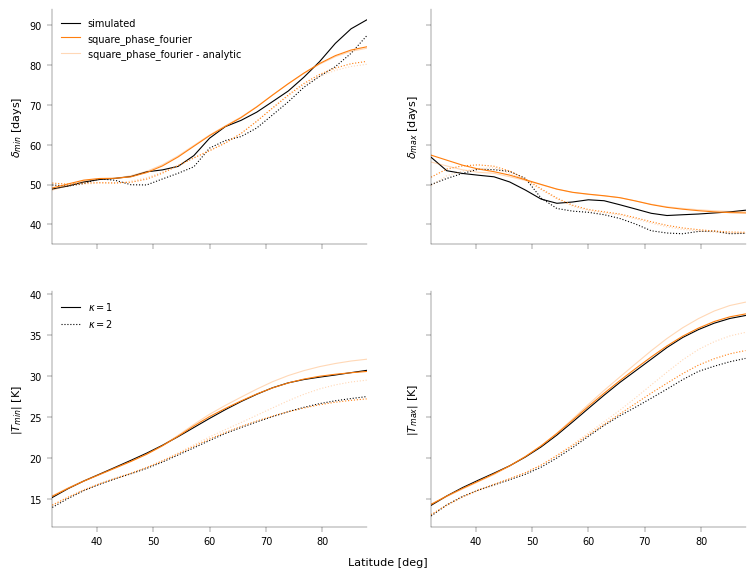

In [17]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    for key2 in ['simulated', 'square_phase_fourier']:
        for j in range(n_exp):
            ax[0, i].plot(ds[j].lat, time_extrema_temp[key][key2][j] - time_extrema_sw[key], color=color_approx[key2],
                          linestyle=linestyle_exp[j], label=key2 if j==0 else None)
            ax[1, i].plot(ds[j].lat, amp_extrema_temp[key][key2][j], color=color_approx[key2],
                          linestyle=linestyle_exp[j], label=labels_exp[j] if key2=='simulated' else None)
            if key2 in temp_anom_numerical:
                ax[0, i].plot(ds[j].lat, time_extrema_temp[key][key2+'_analytic'][j] - time_extrema_sw[key], color=color_approx[key2],
                          linestyle=linestyle_exp[j], alpha=0.3, label=key2+' - analytic' if j==0 else None)
                ax[1, i].plot(ds[j].lat, amp_extrema_temp[key][key2+'_analytic'][j], color=color_approx[key2],
                          linestyle=linestyle_exp[j], alpha=0.3)
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend(loc='upper left')
ax[1, 0].legend(loc='upper left')
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05);
# isca_tools.savefig(fig_extrema, f'extrema')

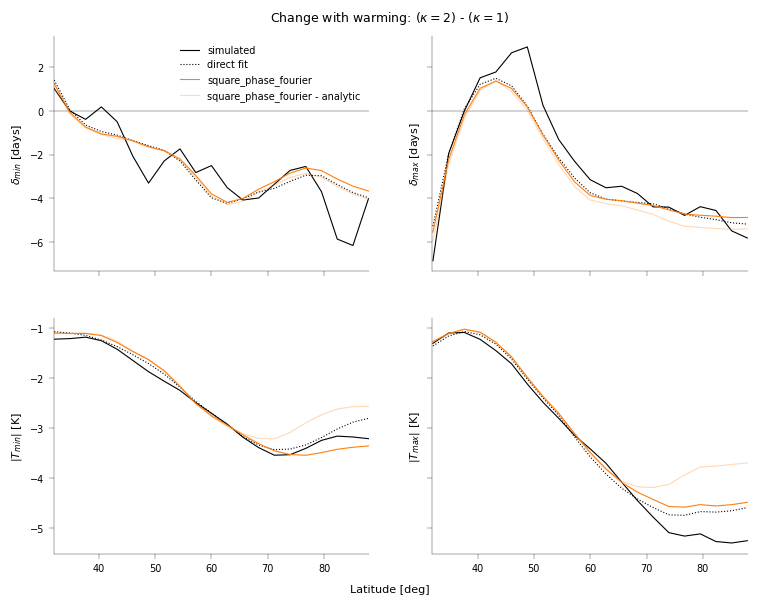

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)
    for key2 in ['simulated', 'direct fit', 'square_phase_fourier']:
        ax[0, i].plot(ds[0].lat, time_extrema_temp[key][key2][1] - time_extrema_temp[key][key2][0], color=color_approx[key2],
                      label=key2, linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds[0].lat, amp_extrema_temp[key][key2][1] - amp_extrema_temp[key][key2][0], color=color_approx[key2],
                      linestyle=linestyle_approx[key2])
        if key2 in temp_anom_numerical:
            ax[0, i].plot(ds[0].lat, time_extrema_temp[key][key2+'_analytic'][1] - time_extrema_temp[key][key2+'_analytic'][0],
                          color=color_approx[key2], alpha=0.3, label=key2+' - analytic')
            ax[1, i].plot(ds[j].lat, amp_extrema_temp[key][key2+'_analytic'][1] - amp_extrema_temp[key][key2+'_analytic'][0],
                          color=color_approx[key2], alpha=0.3)
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend(loc='upper right')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
fig.suptitle(f'Change with warming: ({labels_exp[1]}) - ({labels_exp[0]})', fontsize=9, y=0.92)
plt.show()

### Split into how 1st harmonic changes, and the deviation from 1st harmonic extrema


In [19]:
def split_extrema_into_harmonics(time_extrema, temp_extrema, sw_amp1, lambda_const, extrema_type='min',day_seconds=86400, n_days_year=360):
    # Returns y=sin(2\pi f\Delta) where \Delta=t_extrema - t_extrema_1
    # I.e. the time relative to first harmonic
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity/lambda_const
    time_harmonic1 = np.arctan(x)/(2*np.pi*f)
    if extrema_type == 'max':
        time_harmonic1 = time_harmonic1 + 1/(2*f)
    time_extrema_shift = time_extrema * day_seconds - time_harmonic1
    y = np.sin(2*np.pi*f*time_extrema_shift)
    amp_harmonic1 = np.abs(sw_amp1/lambda_const/np.sqrt(1+x**2))
    return time_harmonic1/day_seconds, amp_harmonic1, time_extrema_shift/day_seconds, np.abs(temp_extrema)-amp_harmonic1

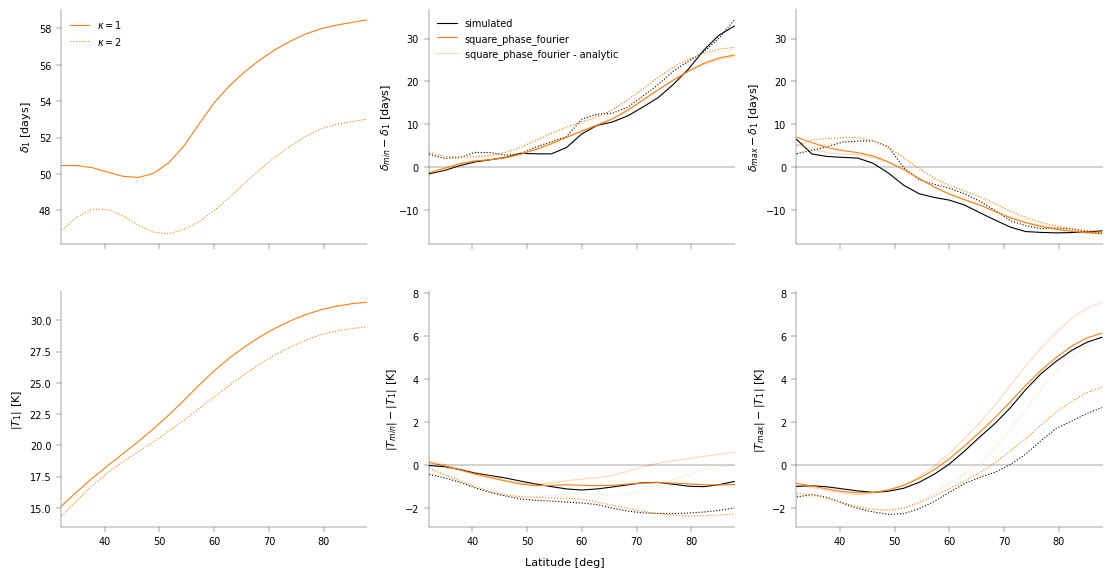

In [20]:
approx_use = 'square_phase_fourier'
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
for i, key in enumerate(time_extrema_temp):
    ax[i, 2].sharey(ax[i, 1])
    ax[i, 1].axhline(0, color='k', lw=ax_linewidth)
    ax[i, 2].axhline(0, color='k', lw=ax_linewidth)
    for key2 in ['simulated', approx_use]:
        for j in range(n_exp):
            time_use1, amp_use1, time_use2, amp_use2 = split_extrema_into_harmonics(time_extrema_temp[key][key2][j], amp_extrema_temp[key][key2][j],
                                                                                    sw_amp_coefs['2_harmonic'][:, 1], gamma_params[approx_use][j, :, 4],
                                                                                    key)
            if key=='min' and key2 != 'simulated':
                ax[0, i].plot(ds[j].lat, time_use1 - time_extrema_sw[key], color=color_approx[key2],
                              linestyle=linestyle_exp[j], label=labels_exp[j])
                ax[1, i].plot(ds[j].lat, amp_use1, color=color_approx[key2],
                              linestyle=linestyle_exp[j], label=labels_exp[j] if key2=='simulated' else None)
            ax[0, i+1].plot(ds[j].lat, time_use2, color=color_approx[key2],
                            linestyle=linestyle_exp[j], label=key2 if j==0 else None)
            ax[1, i+1].plot(ds[j].lat, amp_use2, color=color_approx[key2],
                            linestyle=linestyle_exp[j])
            if key2 in temp_anom_numerical:
                time_use2, amp_use2 = split_extrema_into_harmonics(time_extrema_temp[key][key2+'_analytic'][j],
                                                                   amp_extrema_temp[key][key2+'_analytic'][j], sw_amp_coefs['2_harmonic'][:, 1],
                                                                   gamma_params[approx_use][j, :, 4], key)[2:]
                ax[0, i+1].plot(ds[j].lat, time_use2, color=color_approx[key2],
                          linestyle=linestyle_exp[j], alpha=0.3, label=key2+' - analytic' if j==0 else None)
                ax[1, i+1].plot(ds[j].lat, amp_use2, color=color_approx[key2],
                          linestyle=linestyle_exp[j], alpha=0.3)
    ax[0, i+1].set_ylabel(f"$\delta_{'{'+key+'}'} - \delta_1$ [days]")
    ax[1, i+1].set_ylabel(f"$|T_{'{'+key+'}'}| - |T_1|$ [K]")
ax[0, 0].set_ylabel('$\delta_1$ [days]')
ax[1, 0].set_ylabel('$|T_1|$ [K]')
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 1].legend(loc='upper left')
ax[0, 0].legend(loc='upper left')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05);

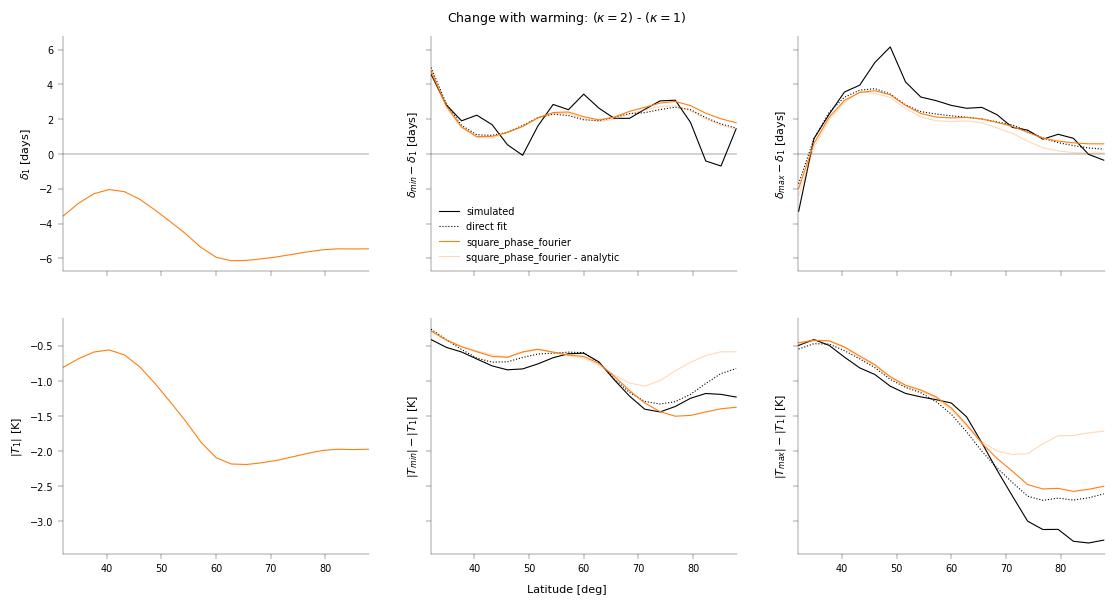

In [21]:
approx_use = 'square_phase_fourier'
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    for key2 in ['simulated', 'direct fit', approx_use]:
        time_use1, amp_use1, time_use2, amp_use2 = split_extrema_into_harmonics(time_extrema_temp[key][key2], amp_extrema_temp[key][key2],
                                                                                sw_amp_coefs['2_harmonic'][:, 1], gamma_params[approx_use][:, :, 4],
                                                                                key)
        if key=='min' and key2==approx_use:
            ax[0, i].plot(ds[j].lat, time_use1[1] - time_use1[0], color=color_approx[key2],
                          linestyle=linestyle_approx[key2], label=labels_exp[j])
            ax[1, i].plot(ds[j].lat, amp_use1[1]-amp_use1[0], color=color_approx[key2],
                          linestyle=linestyle_approx[key2])
        ax[0, i+1].plot(ds[j].lat, time_use2[1]-time_use2[0], color=color_approx[key2],
                        linestyle=linestyle_approx[key2], label=key2)
        ax[1, i+1].plot(ds[j].lat, amp_use2[1]-amp_use2[0], color=color_approx[key2],
                        linestyle=linestyle_approx[key2])
        if key2 in temp_anom_numerical:
            time_use2, amp_use2 = split_extrema_into_harmonics(time_extrema_temp[key][key2+'_analytic'],
                                                               amp_extrema_temp[key][key2+'_analytic'], sw_amp_coefs['2_harmonic'][:, 1],
                                                               gamma_params[approx_use][:, :, 4], key)[2:]
            ax[0, i+1].plot(ds[j].lat, time_use2[1]-time_use2[0], color=color_approx[key2],
                      linestyle=linestyle_approx[key2], alpha=0.3, label=key2+' - analytic')
            ax[1, i+1].plot(ds[j].lat, amp_use2[1]-amp_use2[0], color=color_approx[key2],
                      linestyle=linestyle_approx[key2], alpha=0.3)
    ax[0, i+1].set_ylabel(f"$\delta_{'{'+key+'}'} - \delta_1$ [days]")
    ax[1, i+1].set_ylabel(f"$|T_{'{'+key+'}'}| - |T_1|$ [K]")
for i in range(3):
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_ylabel('$\delta_1$ [days]')
ax[1, 0].set_ylabel('$|T_1|$ [K]')
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 1].legend()
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
fig.suptitle(f'Change with warming: ({labels_exp[1]}) - ({labels_exp[0]})', fontsize=9, y=0.92)
plt.show()

### $\Gamma$ Fitting Parameters
Below we see how each $\lambda$ parameter varies with latitude and the breakdown between fluxes. It is particularly apparent that the temperature independent Fourier contribution is largest at high latitudes.

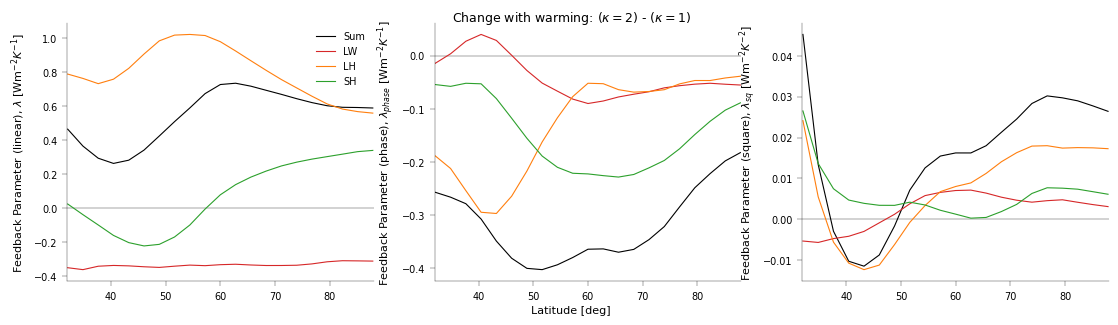

In [59]:
key = 'square_phase_fourier'
plot_change = True
arg_ind = np.append([n_approx_params[key.replace('_fourier', '')]-2, 0], np.arange(1, n_approx_params[key.replace('_fourier', '')]-2))
fig, ax = plt.subplots(1, arg_ind.size, figsize=(im_sz*arg_ind.size*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(len(ax)):
    arg_use = arg_ind[i]+2 if 'fourier' in key else arg_ind[i]
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    for j in range(n_exp-int(plot_change)):
        if i==0 and j==0:
            label_use = 'Sum'
        elif i==1:
            label_use = labels_exp[j]
        else:
            label_use = None
        if plot_change:
            ax[i].plot(ds[j].lat, gamma_params[key][1, :, arg_ind[i]+2] - gamma_params[key][0, :, arg_ind[i]+2], color='k',
                       label=label_use, linestyle=linestyle_exp[j])
        else:
            ax[i].plot(ds[j].lat, gamma_params[key][j, :, arg_ind[i]+2], color='k', label=label_use, linestyle=linestyle_exp[j])
        for key2 in gamma_comp_params:
            if plot_change:
                ax[i].plot(ds[j].lat, gamma_comp_params[key2][key][1, :, arg_use] - gamma_comp_params[key2][key][0, :, arg_use],
                           color=color_approx[key2], label=key2.upper() if j==0 and i==0 else None,
                           linestyle=linestyle_exp[j])
            else:
                ax[i].plot(ds[j].lat, gamma_comp_params[key2][key][j, :, arg_use], color=color_approx[key2],
                           label=key2.upper() if j==0 and i==0 else None,
                           linestyle=linestyle_exp[j])
ax[0].legend(frameon=True, framealpha=1, edgecolor='white', fontsize=7)
if not plot_change:
    ax[1].legend(frameon=True, framealpha=1, edgecolor='white', fontsize=7)
else:
    fig.suptitle(f'Change with warming: ({labels_exp[1]}) - ({labels_exp[0]})', fontsize=9, y=0.92)
ax[0].set_xlim(ax_lims_lat)
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('Feedback Parameter (phase), $\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')
if arg_ind.size>2:
    ax[2].set_ylabel('Feedback Parameter (square), $\lambda_{sq}$ [Wm$^{-2}K^{-2}$]')
# isca_tools.savefig(fig, f'gamma_cont_param', save_if_exists=False)

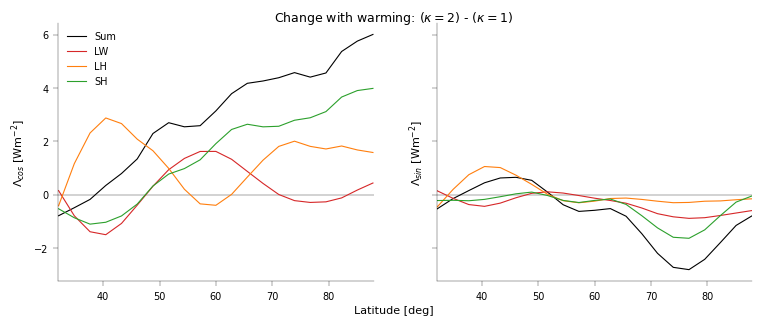

In [55]:
key = 'square_phase_fourier'
plot_change = True
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    for j in range(n_exp-int(plot_change)):
        if i==0 and j==0:
            label_use = 'Sum'
        elif i==1:
            label_use = labels_exp[j]
        else:
            label_use = None
        if plot_change:
            ax[i].plot(ds[j].lat, gamma_params[key][1, :, i]-gamma_params[key][0, :, i], color='k', label=label_use, linestyle=linestyle_exp[j])
        else:
            ax[i].plot(ds[j].lat, gamma_params[key][j, :, i], color='k', label=label_use, linestyle=linestyle_exp[j])
        for key2 in gamma_comp_params:
            if plot_change:
                ax[i].plot(ds[j].lat, gamma_comp_params[key2][key][1, :, i]-gamma_comp_params[key2][key][0, :, i],
                           color=color_approx[key2], label=key2.upper() if i==0 and j==0 else None,
                           linestyle=linestyle_exp[j])
            else:
                ax[i].plot(ds[j].lat, gamma_comp_params[key2][key][j, :, i], color=color_approx[key2], label=key2.upper() if i==0 and j==0 else None,
                           linestyle=linestyle_exp[j])
ax[0].legend(frameon=True, framealpha=1, edgecolor='white', fontsize=7)
if not plot_change:
    ax[1].legend(frameon=True, framealpha=1, edgecolor='white', fontsize=7)
else:
    fig.suptitle(f'Change with warming: ({labels_exp[1]}) - ({labels_exp[0]})', fontsize=9, y=0.92)
ax[0].set_xlim(ax_lims_lat)
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0].set_ylabel('$\Lambda_{cos}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$\Lambda_{sin}$ [Wm$^{-2}$]');